# imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import wbdata
import matplotlib.pyplot as plt
import scipy.stats as st
from sympy import *
import time as dt
import warnings
from IPython.display import Math,Latex
from pandas.errors import SettingWithCopyWarning

from sklearn.linear_model import LinearRegression
from statsmodels.api import *
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures,StandardScaler,MinMaxScaler

from scipy.stats import jarque_bera, kstest, kstwobign


In [2]:
from country_dict import *

import os
from docx import Document
from docx.shared import Inches, Pt
from docx.table import Table
from openpyxl import load_workbook
from deep_translator import GoogleTranslator
from docx.enum.text import WD_ALIGN_PARAGRAPH
#########################
import locale
locale.setlocale(locale.LC_NUMERIC, 'russian')
plt.rcParams['axes.formatter.use_locale'] = True
#########
#########
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['mathtext.fontset'] = 'cm'
###################
init_printing(use_unicode=True,use_latex=True)
###################
def add_excel_table_to_docx(xlsx_file, docx_file, sheet_name='Sheet1',from_row=1):
    """Добавляет таблицу из указанного листа Excel в документ Word.

    Args:
        xlsx_file (str): Путь к файлу Excel.
        docx_file (str): Путь к документу Word.
        sheet_name (str, optional): Название листа в Excel. По умолчанию 'Лист1'.
    """

    # Загрузка данных из Excel
    workbook = load_workbook(xlsx_file)
    worksheet = workbook[sheet_name]

    # Создание нового документа Word или открытие существующего
    document = Document(docx_file)

    # Создание таблицы в документе Word
    table = document.add_table(rows=worksheet.max_row, cols=worksheet.max_column)

    # Заполнение ячеек таблицы данными из Excel
    for row_idx in range(from_row, worksheet.max_row + 1):
        for col_idx in range(1, worksheet.max_column + 1):
            cell = table.cell(row_idx - 1, col_idx - 1)
            cell.text = str(worksheet.cell(row=row_idx, column=col_idx).value)

    # Сохранение документа Word
    document.save(docx_file)
###################
def add_text(docx_file,text:str,font_name='Times New Roman',font_size=12,par_allign='CENTER'):
    alligments={
        'CENTER': WD_ALIGN_PARAGRAPH.CENTER,
        'LEFT':WD_ALIGN_PARAGRAPH.LEFT,
        'RIGHT':WD_ALIGN_PARAGRAPH.RIGHT,
    }
    document = Document(docx_file)
    paragraph = document.add_paragraph()
    paragraph.alignment = alligments[par_allign]  # Выравнивание по центру (можно изменить)
    run = paragraph.add_run(text)
    run.font.size=Pt(font_size)
    run.font.name=font_name
    document.save(docx_file)
###################
def add_image_to_docx(docx_file, image_path, indent_size=-2, width=10.0):
    indent_size=Inches(indent_size)
    width=Inches(width)
    """Добавляет изображение PNG в документ DOCX с заданным отступом слева.

    Args:
        docx_file (str): Путь к существующему или новому DOCX файлу.
        image_path (str): Путь к изображению PNG.
        indent_size (Inches, optional): Размер отступа слева в дюймах. По умолчанию 0.5 дюйма.
        width (Inches, optional): Ширина изображения в дюймах. По умолчанию 3 дюйма.
    """

    document = Document(docx_file)
    paragraph = document.add_paragraph()
    paragraph.alignment = WD_ALIGN_PARAGRAPH.CENTER  # Выравнивание по центру (можно изменить)
    run = paragraph.add_run()
    run.add_picture(image_path, width=width)
    paragraph.paragraph_format.first_line_indent = indent_size
    document.save(docx_file)
###################


# Возьмем данные из библиотеки `wbdata`

In [3]:
country = 'RUS'
document = Document()
indicators = {
    #'NY.'Inflation rate'.DEFL.KD.ZG': 'Inflation rate',
    'FP.CPI.TOTL': 'Inflation rate',
    'SL.UEM.TOTL.ZS': 'Unemployment rate',
}
data = wbdata.get_dataframe(indicators, country=country )

data = data.dropna().sort_values('date')

try:
    os.mkdir(f'{country}')
    os.chdir(f'{country}')
except:
    os.chdir(f'{country}')


try:
    data.to_excel(f'{country}_1.xlsx')
except:
    pass

display(data)


document.save(f'{country}.docx')
add_text(f'{country}.docx',f'Кривая Филлипса для страны {country_dict[country]}',font_size=15)
add_text(f'{country}.docx',f'\tПолучим данные о динамике безработицы(Inflation rate (%)) и динамике безработицы(Unemployment rate (%)) из статистики Мирового Банка о стране {country_dict[country]}.',par_allign='LEFT')
add_excel_table_to_docx(f'{country}_1.xlsx',f'{country}.docx')

,Inflation rate,Unemployment rate
date,,
1992,0.053596,5.181
1993,0.522155,5.883
1994,2.128943,8.131
1995,6.331779,9.449
1996,9.355331,9.665
1997,10.736302,11.813
1998,13.708721,13.261
1999,25.463468,13.036
2000,30.759554,10.581


# Стандартизируем полученные данные

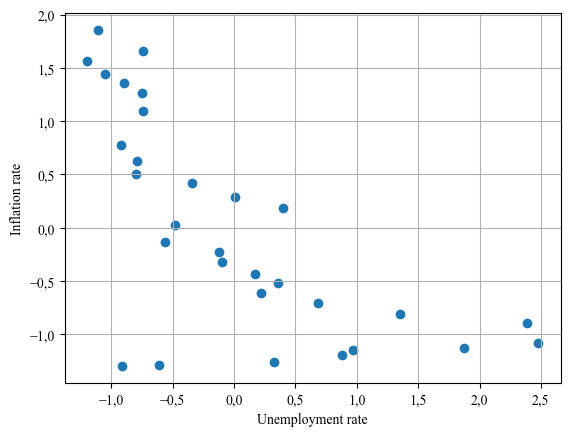

In [4]:
s=StandardScaler()
x=s.fit_transform(data[['Unemployment rate']])
s=StandardScaler()
y=s.fit_transform(data[['Inflation rate']])


plt.xlabel('Unemployment rate')
plt.ylabel('Inflation rate')
plt.grid()
plt.scatter(x,y)

try:
    plt.savefig(f'{country}_2.png')
except:
    pass

add_text(f'{country}.docx','\n\nСтандартизируем полученнные данные и выведем получившеееся распределение точек')
add_image_to_docx(f'{country}.docx',f'{country}_2.png',0,5)

plt.show()

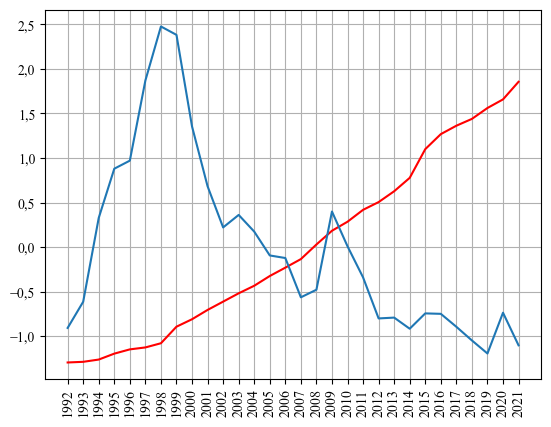

In [5]:
plt.plot(data.index,y,color='r')
plt.plot(data.index,x)
plt.xticks(rotation=90)
plt.grid()

try:
    plt.savefig(f'{country}_3.png')
except:
    pass

add_text(f'{country}.docx','\n\nПроведем анализ изменения инфляции и безработицы в стране.')
add_image_to_docx(f'{country}.docx',f'{country}_3.png',0,5)

plt.show()

In [6]:
maxgdp_year=int(*data[data['Inflation rate']==max(data['Inflation rate'])].index)
maxunemp_year=int(*data[data['Unemployment rate']==max(data['Unemployment rate'])].index)
mingdp_year=int(*data[data['Inflation rate']==min(data['Inflation rate'])].index)
minunemp_year=int(*data[data['Unemployment rate']==min(data['Unemployment rate'])].index)


add_text(f'{country}.docx',f'\tКак видно из графиков, за рассматриваемый период инфляция достигла максимального значения в {maxgdp_year} году, а безработица в {maxunemp_year} году, а минимумы в {mingdp_year} и {minunemp_year} годах соответственно для инфляции и безработицы.',par_allign='LEFT')


# построим модель линейной регрессии

In [7]:
x1 = add_constant(x)
model = OLS(y,x1).fit()

model.summary().as_text()

text = '\n\nПостроим модель линейной регрессии на получившихся данных\n\n' + model.summary().as_text() + 'Как видно, качество модели мало'

add_text(f'{country}.docx',text,par_allign='CENTER')

# Построим модель гиперболической функции

In [8]:
x1 = add_constant(x)
x1 = x1/x
model = OLS(y,x1).fit()

model.summary().as_text()

text = '\n\nПостроим модель гиперболической функции:\n\n' + model.summary().as_text() + 'Как видно, качество модели также мало'

add_text(f'{country}.docx',text,par_allign='CENTER')

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.035
Method:                 Least Squares   F-statistic:                  0.009688
Date:                Sun, 03 Nov 2024   Prob (F-statistic):              0.922
Time:                        21:07:53   Log-Likelihood:                -42.563
No. Observations:                  30   AIC:                             89.13
Df Residuals:                      28   BIC:                             91.93
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0009      0.009      0.098      0.922      -0.017       0.019
const         -0.0030      0.191     -0.015      0.988      -0.395       0.389
==============================================================================
Omnibus:                        5.862   Durbin-Watson:                   0.016
Prob(Omnibus):                  0.053   Jarque-Bera (JB):                2.365
Skew:                           0.350   Prob(JB):                        0.307
Kurtosis:                       1.816   Cond. No.                         21.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Как видно, гиперболическая функция еще хуже описывает ситуацию

# Попробуем совершить полиномиальные преобразования

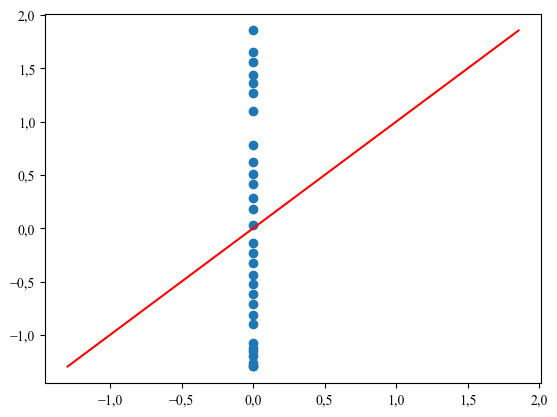

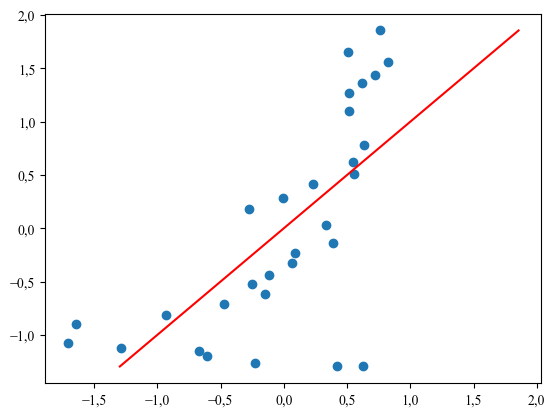

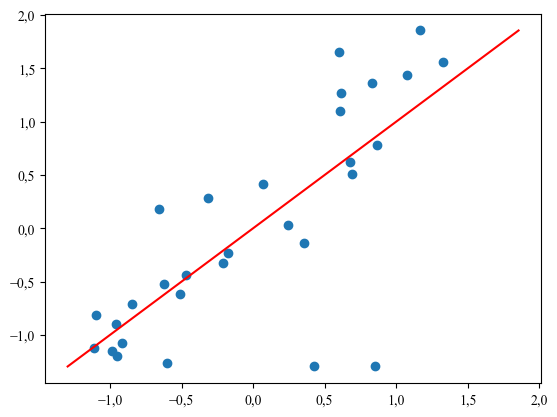

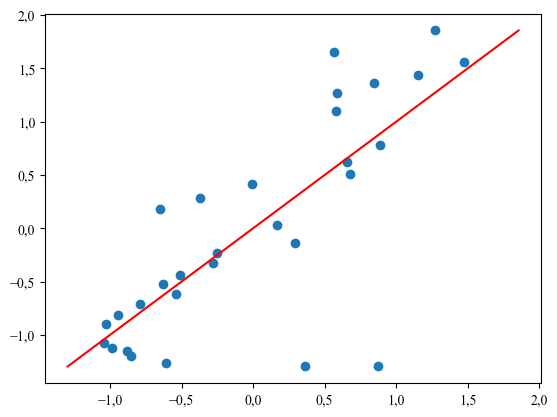

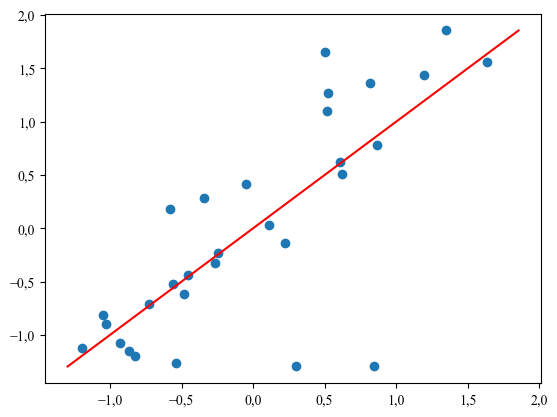

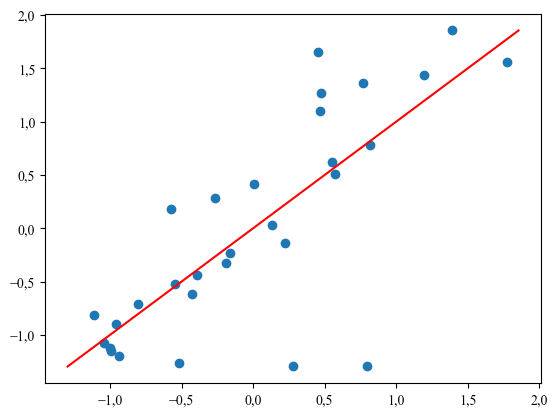

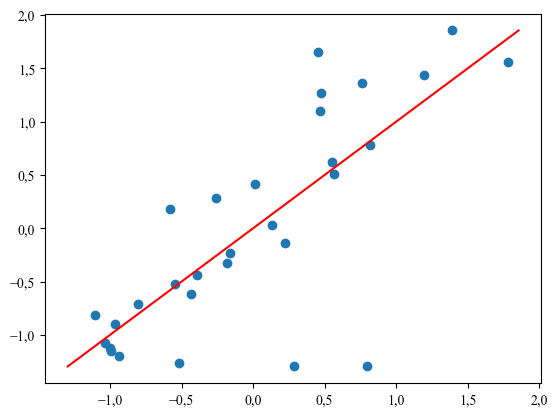

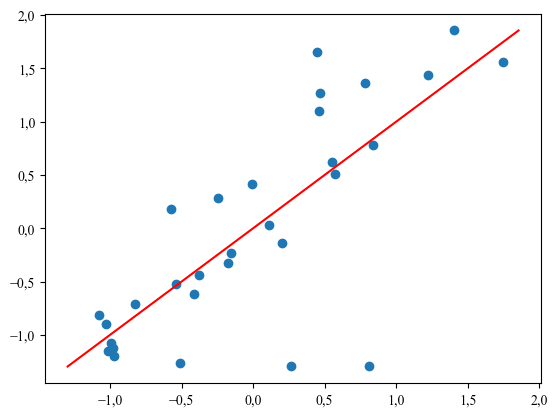

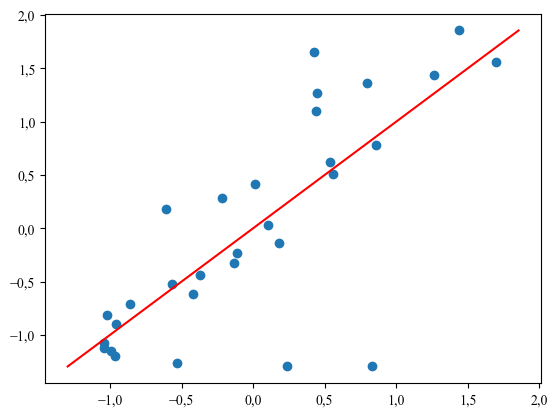

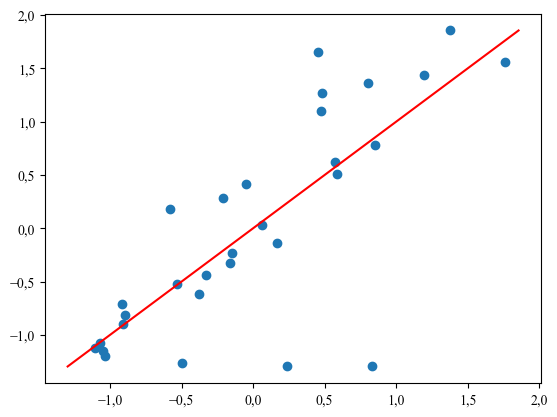

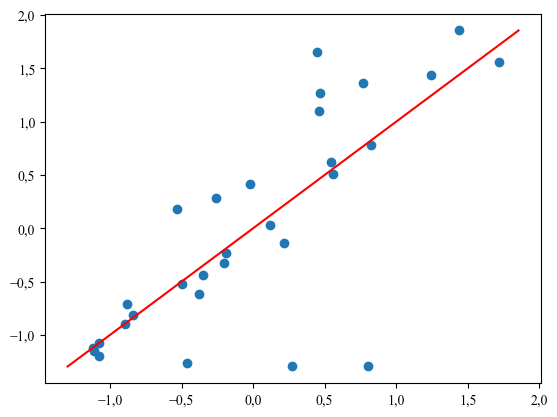

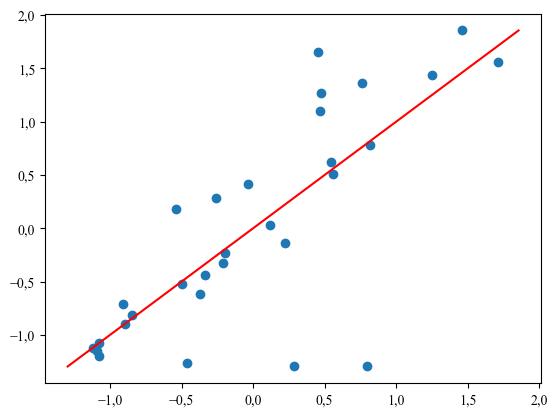

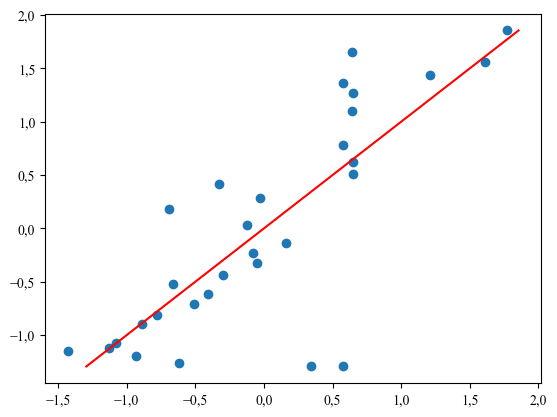

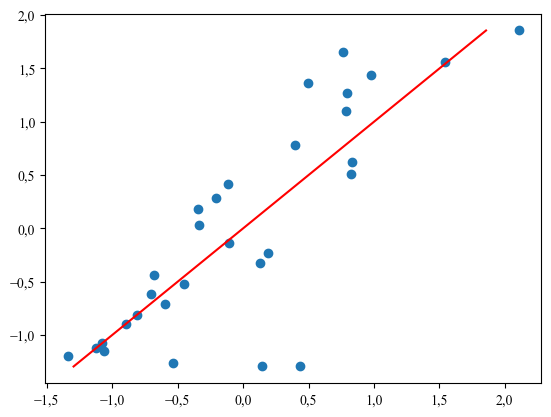

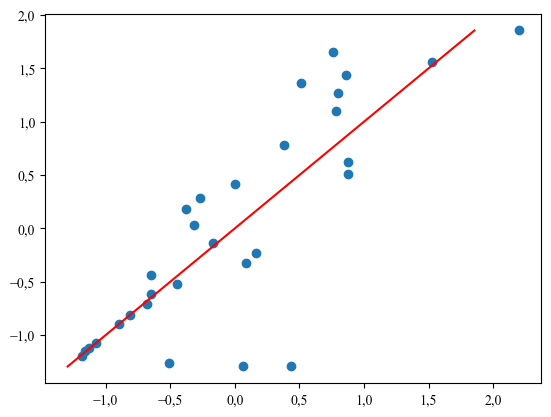

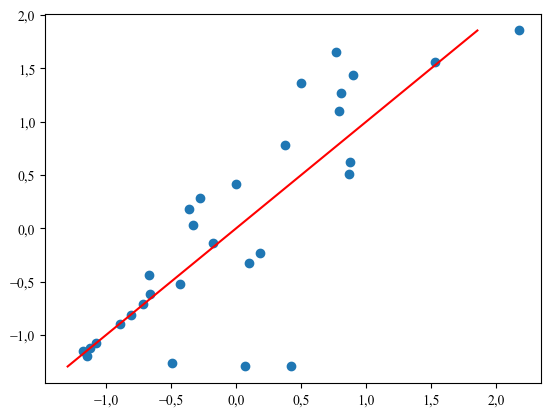

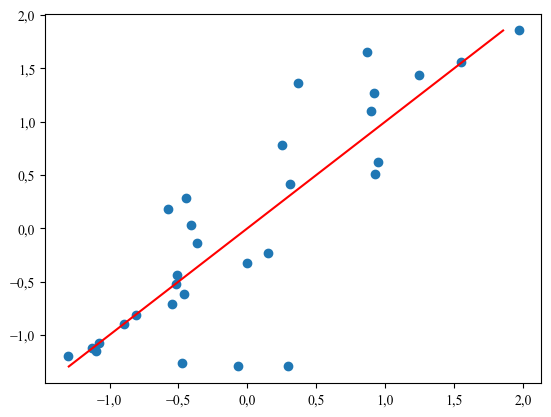

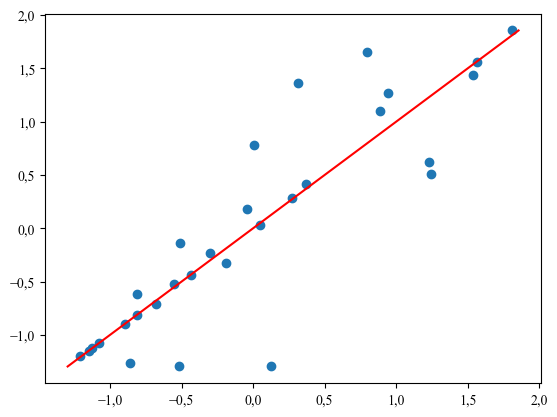

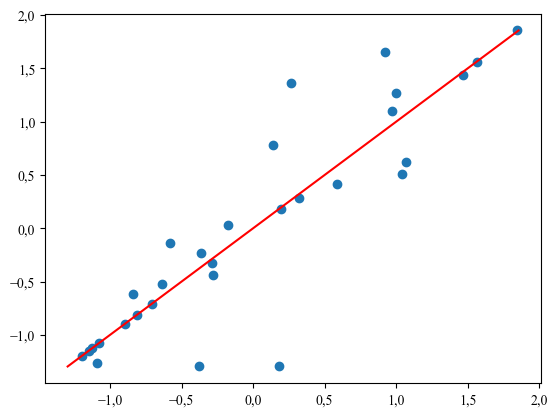

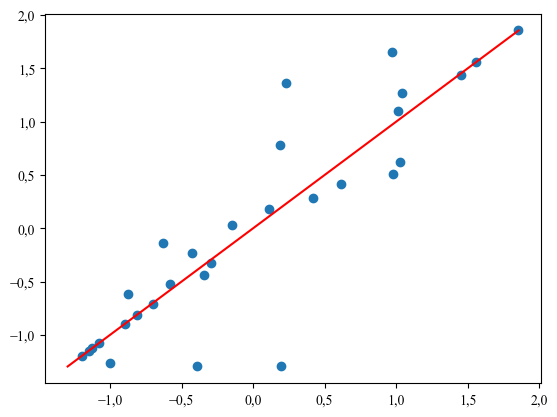

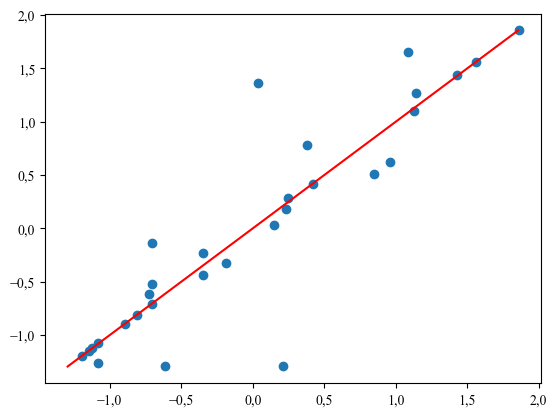

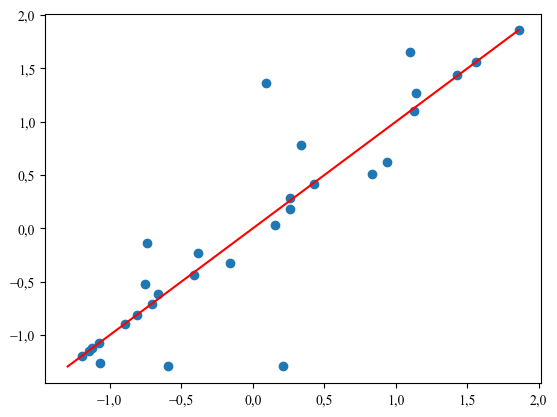

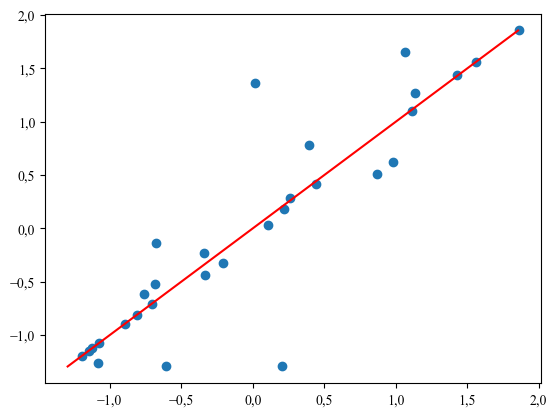

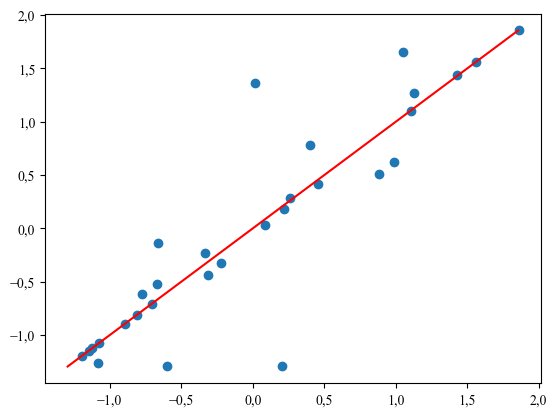

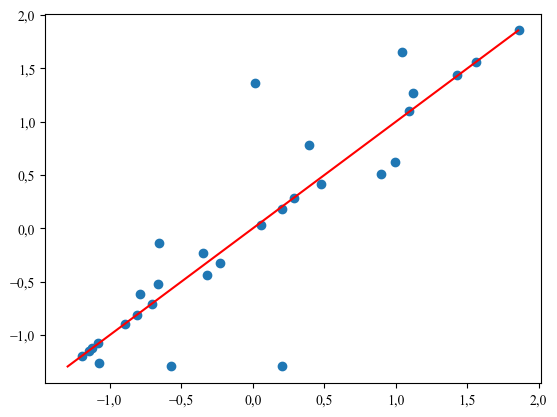

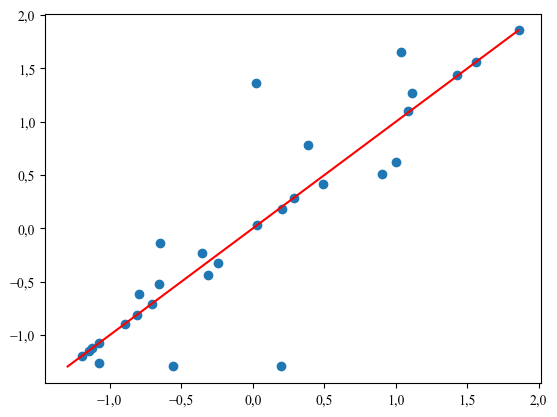

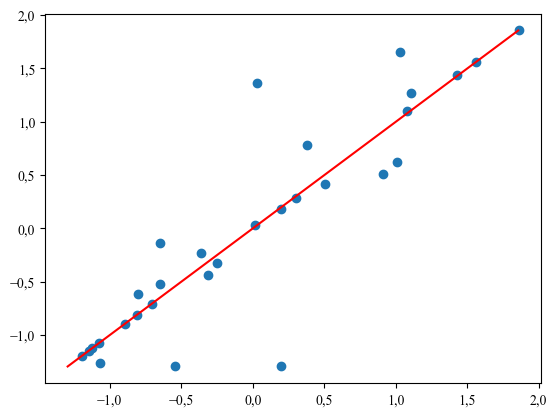

In [9]:
add_text(f'{country}.docx','Попробуем совершить полиномиальные преобразования',par_allign='CENTER')
deg =0 

r=0
while round(r,3)<=0.95:
        xp=x
        pf = PolynomialFeatures(degree=deg)
        xp = pf.fit_transform(xp)
        
        model = OLS(y,xp).fit()
        
        display((deg, model.rsquared))
        plt.scatter(model.predict(xp), y)
        plt.plot([np.min(y),np.max(y)],[np.min(y),np.max(y)],color='red')
        
        if True:
                
                try:
                        plt.savefig(f'{country}_x_deg_{deg}.png')
                        add_text(f'{country}.docx',f'Степень полинома = {deg},\nR2 значение модели = {model.rsquared}')
                        add_image_to_docx(f'{country}.docx',f'{country}_x_deg_{deg}.png',0,5)
                except:
                        pass
        plt.show()
        deg +=1
        r = model.rsquared
        
        if deg==27:
                break
else:
        xp=x
        pf = PolynomialFeatures(degree=deg)
        xp = pf.fit_transform(xp)
        
        model = OLS(y,xp).fit()
        
        display((deg, model.rsquared))
        plt.scatter(model.predict(xp), y)
        plt.plot([np.min(y),np.max(y)],[np.min(y),np.max(y)],color='red')
        
        if True:
                
                try:
                        plt.savefig(f'{country}_x_deg_{deg}.png')
                        add_text(f'{country}.docx',f'Степень полинома = {deg},\nR2 значение модели = {model.rsquared}')
                        add_image_to_docx(f'{country}.docx',f'{country}_x_deg_{deg}.png',0,5)
                except:
                        pass
        plt.show()

# Все равно R2 мал. 

# Если смотреть на график распределения под углом в 90 градусов, то можно предположить, что это полином степени N

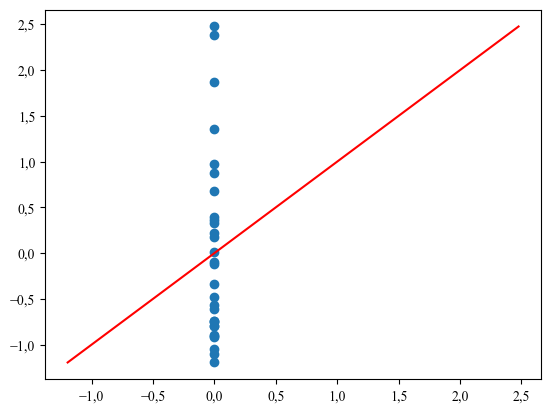

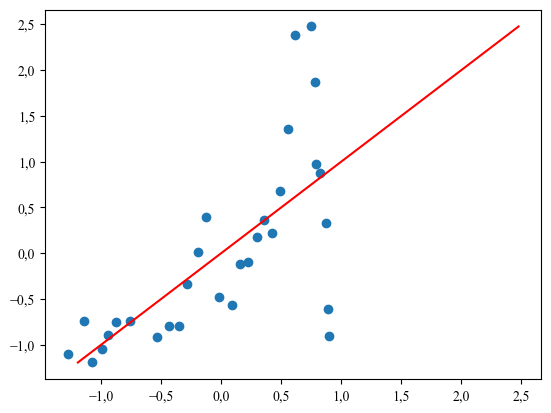

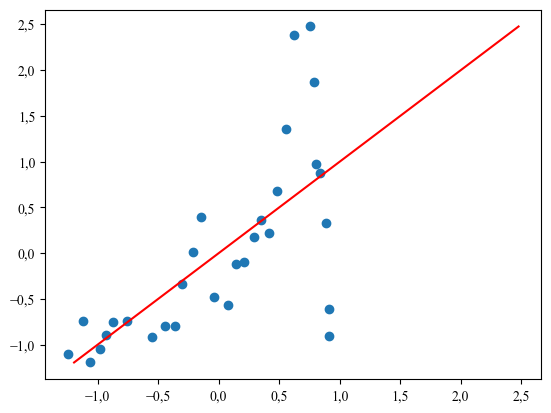

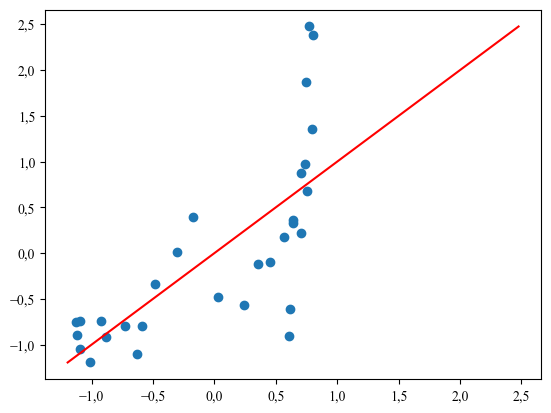

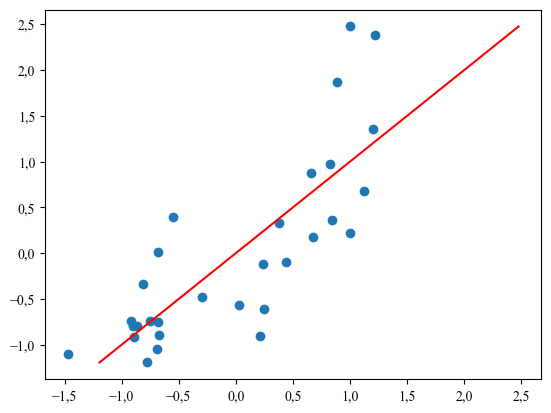

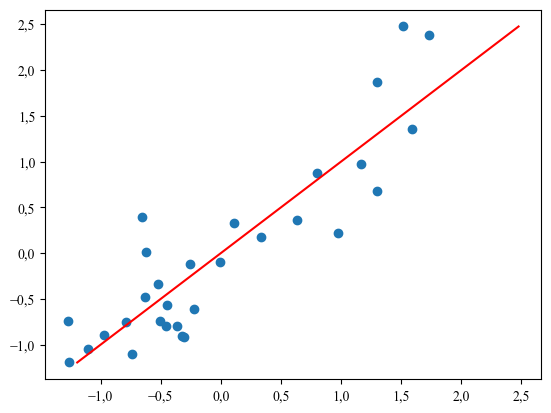

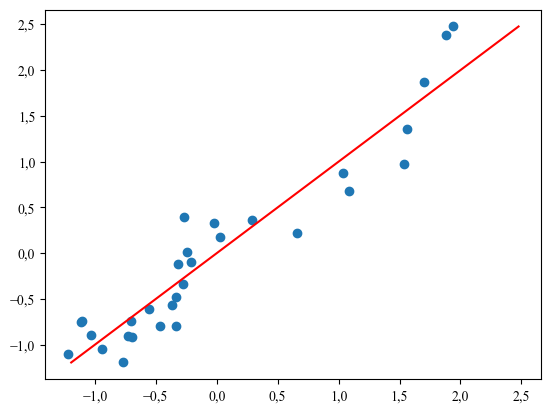

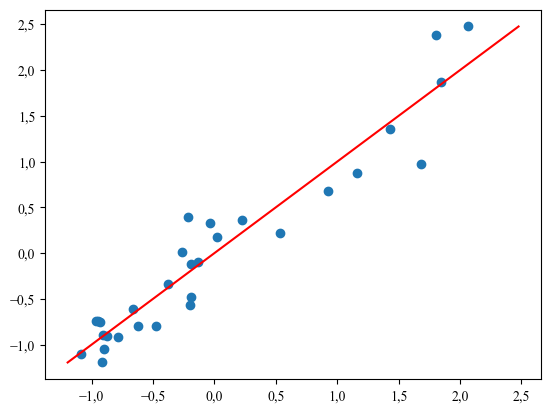

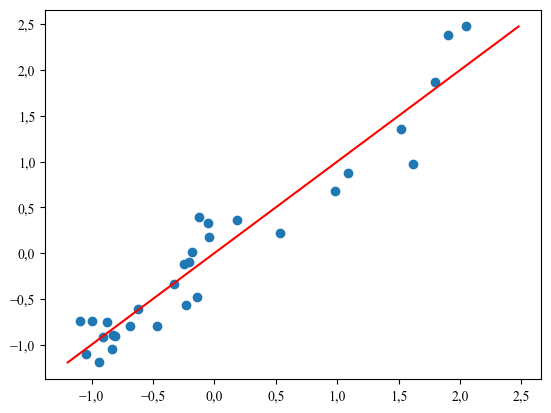

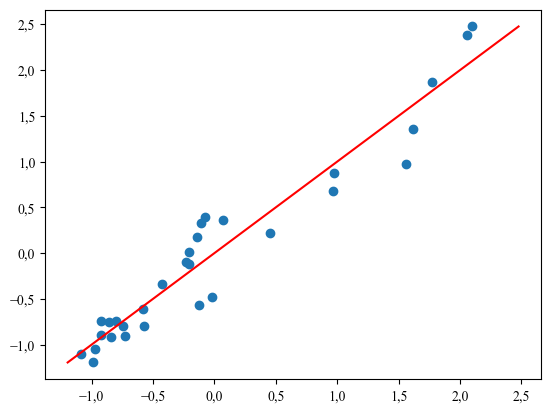

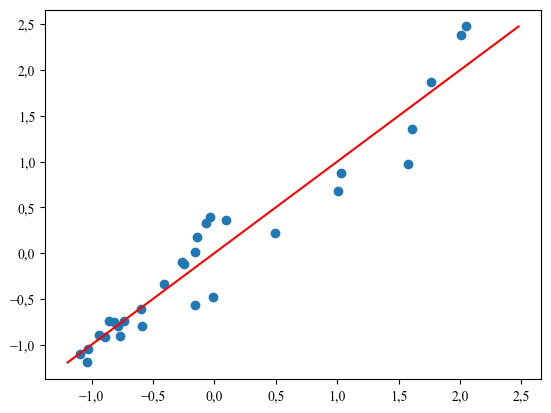

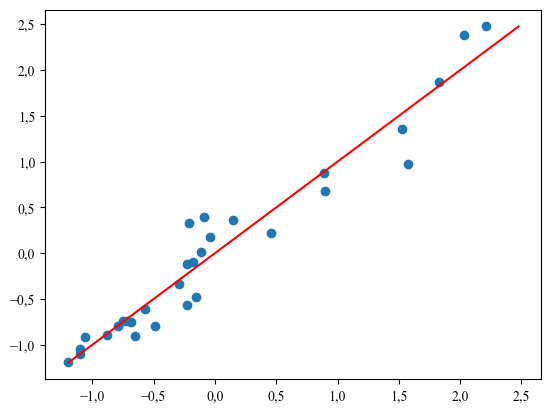

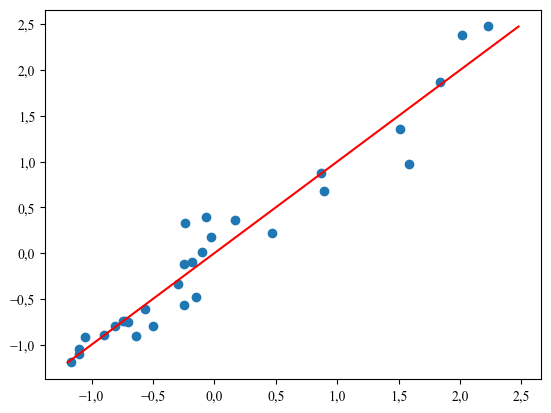

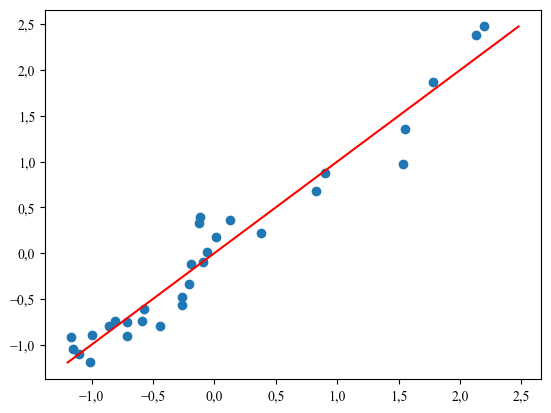

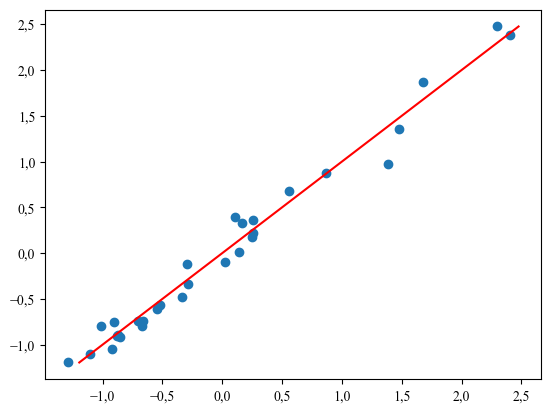

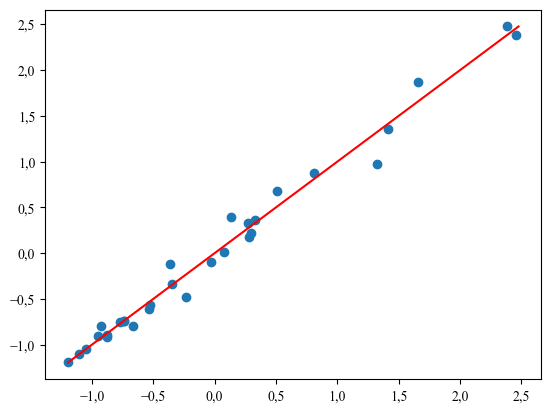

In [10]:
add_text(f'{country}.docx',f'Все равно R2 счет мал.\n\n Если смотреть на график распределения под углом в 90 градусов, то можно предположить, что это полином степени N.\n Попробуем сменить зависимую свободную переменные местами и построить модель.')
deg =0 
r=0
while round(r, 3)<=0.95:
        yp=y
        pf = PolynomialFeatures(degree=deg)
        yp = pf.fit_transform(yp)
        
        model = OLS(x,yp).fit()
        
        display((deg, model.rsquared))
        plt.scatter(model.predict(yp), x)
        plt.plot([np.min(x),np.max(x)],[np.min(x),np.max(x)],color='red')
        
        if True:
                
                try:
                        plt.savefig(f'{country}_y_deg_{deg}.png')
                        add_text(f'{country}.docx',f'Степень полинома = {deg},\nR2 значение модели = {model.rsquared}')
                        add_image_to_docx(f'{country}.docx',f'{country}_y_deg_{deg}.png',0,5)
                except:
                        pass

        
        
        plt.show()
        
        deg +=1
        r = model.rsquared
        if deg==27:
                break
else:
        yp=y
        pf = PolynomialFeatures(degree=deg)
        yp = pf.fit_transform(yp)
        
        model = OLS(x,yp).fit()
        
        display((deg, model.rsquared))
        plt.scatter(model.predict(yp), x)
        plt.plot([np.min(x),np.max(x)],[np.min(x),np.max(x)],color='red')
        
        if True:
                
                try:
                        plt.savefig(f'{country}_y_deg_{deg}.png')
                        add_text(f'{country}.docx',f'Степень полинома = {deg},\nR2 значение модели = {model.rsquared}')
                        add_image_to_docx(f'{country}.docx',f'{country}_y_deg_{deg}.png',0,5)
                except:
                        pass

        
        
        plt.show()

# Мы нашли модель со `R2 = 0.999780516437845`

In [11]:
add_text(f'{country}.docx', f'Мы нашли модель с R2 = {model.rsquared}')
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     56.17
Date:                Sun, 03 Nov 2024   Prob (F-statistic):           6.95e-10
Time:                        21:08:50   Log-Likelihood:                 19.140
No. Observations:                  30   AIC:                            -6.279
Df Residuals:                      14   BIC:                             16.14
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3237      0.133     -2.430      0.029      -0.609      -0.038
x1             2.8974      0.696      4.165      0.001       1.405       4.390
x2             5.4271      3.226      1.682      0.115      -1.492      12.346
x3           -41.8374      8.200     -5.102      0.000     -59.424     -24.251
x4           -28.2627     22.167     -1.275      0.223     -75.806      19.281
x5           168.4035     32.915      5.116      0.000      97.808     238.999
x6            28.7487     65.076      0.442      0.665    -110.825     168.322
x7          -317.3927     58.564     -5.420      0.000    -442.999    -191.786
x8            59.2249     97.633      0.607      0.554    -150.177     268.627
x9           287.3269     49.952      5.752      0.000     180.190     394.464
x10         -125.7777     79.213     -1.588      0.135    -295.673      44.117
x11         -113.9777     20.957     -5.439      0.000    -158.927     -69.029
x12           78.6059     33.087      2.376      0.032       7.642     149.569
x13            9.5000      6.923      1.372      0.192      -5.349      24.349
x14          -16.4687      5.564     -2.960      0.010     -28.403      -4.535
x15            3.1780      1.633      1.946      0.072      -0.324       6.680
==============================================================================
Omnibus:                        2.719   Durbin-Watson:                   2.946
Prob(Omnibus):                  0.257   Jarque-Bera (JB):                1.462
Skew:                          -0.219   Prob(JB):                        0.481
Kurtosis:                       3.989   Cond. No.                     1.04e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Тестируем

# Проверим остатки на нормальность визуально

In [12]:
add_text(f'{country}.docx', f'\n\n Проведем тестирование модели. \n\n Проверим остатки на нормальность визуально')

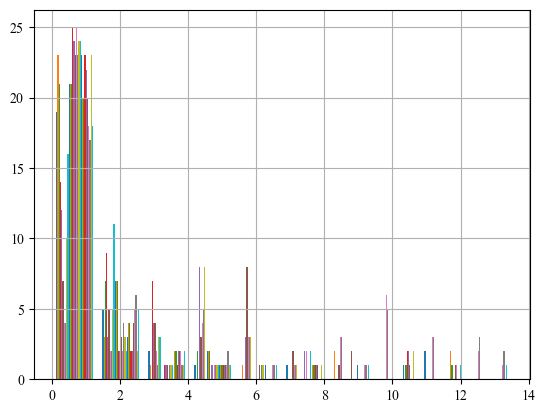

In [13]:
ost = (x-model.predict(yp))**2
plt.hist(ost)
plt.grid()

try:
    plt.savefig(f'{country}_5.png')
except:
    pass

add_image_to_docx(f'{country}.docx',f'{country}_5.png')
plt.show()

# Расскажем про Тест Колмогорова - Смирнова

In [14]:
ks_teor = """
Тест Колмогорова-Смирнова (или K-S тест) — это непараметрический статистический тест, применяемый для проверки соответствия распределения выборки заданному теоретическому распределению. Тест позволяет оценить, насколько эмпирическое распределение данных совпадает с нормальным распределением или с любым другим теоретическим распределением.

Основные этапы алгоритма теста Колмогорова-Смирнова:
Сбор данных. Получаем выборку, для которой нужно проверить соответствие распределению.

Определение теоретического распределения. Выбираем теоретическое распределение, с которым будем сравнивать данные (например, нормальное, равномерное и т.д.).

Построение эмпирической функции распределения (ЭФР):

Вычисляем кумулятивные частоты значений в выборке, чтобы построить эмпирическую функцию распределения.

Построение теоретической функции распределения (ТФР):

На основе выбранного теоретического распределения рассчитываем его кумулятивную функцию распределения для каждого значения в выборке.

Вычисление статистики Колмогорова-Смирнова:

Определяем максимальное отклонение между эмпирической и теоретической функциями распределения: D = max | F_эмп(x) - F_теор(x) |, где F_эмп(x) — значение эмпирической функции распределения, F_теор(x) — значение теоретической функции распределения для каждого значения x в выборке.

Сравнение с критическим значением:

Полученное значение D сравнивается с критическим значением для заданного уровня значимости (обычно 0,05 или 0,01), которое зависит от объема выборки.
Если D превышает критическое значение, гипотеза о совпадении распределений отклоняется.

Интерпретация результатов:

Если D меньше критического значения: гипотеза о том, что данные следуют теоретическому распределению, не отклоняется.
Если D больше критического значения: гипотеза о соответствии распределению отклоняется, что говорит о значительных отклонениях данных от выбранного распределения.

Тест Колмогорова-Смирнова часто используется для проверки нормальности и других распределений. Он также применим для двухвыборочного теста, когда нужно проверить, принадлежат ли две выборки одному и тому же распределению.
"""
add_text(f'{country}.docx', f'\n\nK-S тест',font_size=15)
add_text(f'{country}.docx', ks_teor,font_size=12, par_allign='LEFT')

# Jarque-Bera

In [15]:
jb_teor= '''

Тест Джарка-Бера (Jarque-Bera) — это статистический тест, используемый для проверки нормальности распределения данных. Он основывается на оценке асимметрии (сместности) и эксцесса (пиковости) распределения, чтобы определить, насколько распределение данных отличается от нормального.

Основные этапы алгоритма теста Джарка-Бера:
Сбор данных. Получаем выборку, для которой нужно проверить нормальность.

Вычисление параметров:

n: объем выборки.
Среднее значение выборки.
Стандартное отклонение выборки.


Рассчитываем асимметрию и эксцесс:

Асимметрия (skewness). Измеряет, насколько данные симметричны относительно среднего. Формула: S = (1/n) * сумма [(x_i - среднее) / стандартное отклонение]^3.
Эксцесс (kurtosis). Показывает, насколько распределение «пикообразно» или «плосковершинно». Формула: K = (1/n) * сумма [(x_i - среднее) / стандартное отклонение]^4 - 3.

Расчет статистики теста Джарка-Бера: JB = (n/6) * (S^2 + (K^2)/4). Чем больше значение JB, тем сильнее отклонение от нормальности.

Сравнение с критическим значением:

Полученное значение статистики JB сравнивается с критическим значением из распределения хи-квадрат с 2 степенями свободы на выбранном уровне значимости (обычно 0,05).

Если JB превышает критическое значение, то гипотеза нормальности отклоняется.

Интерпретация результатов:
Если JB меньше критического значения: гипотеза о нормальности не отклоняется, и можно предположить, что данные распределены нормально.
Если JB больше критического значения: гипотеза о нормальности отклоняется, что говорит о наличии значительной асимметрии или отклонений от нормальной формы распределения.

Этот тест полезен для предварительного анализа данных и проверки предположения о нормальности, что важно во многих статистических методах и эконометрических моделях.'''

In [16]:
add_text(f'{country}.docx', f'\n\nJarque-Bera',font_size=15)
add_text(f'{country}.docx', jb_teor,font_size=12, par_allign='LEFT')
jb_stat, jb_p_value = jarque_bera(model.resid)
print("Статистика Jarque-Bera:", jb_stat)
add_text(f'{country}.docx', f'Статистика Jarque-Bera: {jb_stat}')

print("p-значение:", jb_p_value)
add_text(f'{country}.docx', f'p-значение: {jb_p_value}')

if jb_p_value < 0.05:
    print("Данные не распределены нормально")
    add_text(f'{country}.docx', "Данные не распределены нормально")
else:
    print('Данные распределены нормально')
    add_text(f'{country}.docx', "Данные распределены нормально")

Статистика Jarque-Bera: 1.4622846121728859
p-значение: 0.4813588168106787
Данные распределены нормально


# Shapiro-Wilk

In [17]:
add_text(f'{country}.docx', f'\n\nShapiro-Wilk',font_size=15)

stat, p_value = st.shapiro(model.resid)
print("Статистика Shapiro-Wilk:", stat)
add_text(f'{country}.docx', f'Статистика Shapiro-Wilk: {stat}')

print("p-значение:", p_value)
add_text(f'{country}.docx', f'p-значение: {p_value}')

if p_value > 0.05:
    print("Распределение данных похоже на нормальное")
    add_text(f'{country}.docx', "Распределение данных похоже на нормальное")
else:
    print('Распределение данных отличается от нормального')
    add_text(f'{country}.docx', "Распределение данных отличается от нормального")

Статистика Shapiro-Wilk: 0.9494766810692478
p-значение: 0.1636875606933047
Распределение данных похоже на нормальное


# Helwig

In [18]:
add_text(f'{country}.docx', f'\n\nHelwig',font_size=15)

def helwig_test(data):
    # Шаг 1: Сортируем данные и определяем размер выборки
    add_text(f'{country}.docx', f'Шаг 1: Сортируем данные и определяем размер выборки')
    data_sorted = np.sort(data)
    n = len(data)

    # Шаг 2: Оценка среднего и стандартного отклонения
    add_text(f'{country}.docx', f'Шаг 2: Оценка среднего и стандартного отклонения')
    mean, std = np.mean(data), np.std(data, ddof=1)

    # Шаг 3: Вычисляем эмпирическую функцию распределения (ЭФР)
    add_text(f'{country}.docx', f'Шаг 3: Вычисляем эмпирическую функцию распределения (ЭФР)')
    ecdf = np.arange(1, n + 1) / n  

    # Шаг 4: Строим теоретическую нормальную функцию распределения (НФР)
    theoretical_cdf = st.norm.cdf(data_sorted, mean, std)
    add_text(f'{country}.docx', 'Шаг 4: Строим теоретическую нормальную функцию распределения (НФР)')

    # Шаг 5: Вычисляем максимальное отклонение между ЭФР и НФР
    add_text(f'{country}.docx','Шаг 5: Вычисляем максимальное отклонение между ЭФР и НФР')
    max_deviation = np.max(np.abs(ecdf - theoretical_cdf))

    # Вывод результата
    add_text(f'{country}.docx','Вывод результата')
    
    print("Максимальное отклонение (D):", max_deviation)
    add_text(f'{country}.docx',f'Максимальное отклонение (D): {max_deviation}')
    return max_deviation

n = len(model.resid)

alpha = 0.05
critical_value = kstwobign.ppf(1 - alpha) / np.sqrt(n)
if helwig_test(model.resid) > critical_value:
    print(f"Гипотеза о нормальности отвергается на уровне значимости {alpha}.")
    add_text(f'{country}.docx',f"Гипотеза о нормальности отвергается на уровне значимости {alpha}.")
else:
    print(f"Нет оснований отвергнуть гипотезу о нормальности на уровне значимости {alpha}.")
    add_text(f'{country}.docx',f"Нет оснований отвергнуть гипотезу о нормальности на уровне значимости {alpha}.")

Максимальное отклонение (D): 0.11388137902302198
Нет оснований отвергнуть гипотезу о нормальности на уровне значимости 0.05.


# Сравнение тестов

In [19]:
t = '''Сравнение методов согласия Хельвига, Шапиро-Вилька и Джарка-Бера (Jarque-Bera) полезно для выбора подходящего теста для проверки нормальности распределения данных. Каждый из этих методов имеет свою область применения и особенности, которые могут быть полезны в разных контекстах.

1. Тест Хельвига
Цель: Метод Хельвига основан на анализе корреляций и используется для оценки согласия признаков, особенно в социально-экономических и психометрических исследованиях.
Применение: Обычно применяется для оценки многомерного согласия признаков или при проведении факторного анализа.
Преимущества:
Хорошо подходит для многомерных данных, поскольку анализирует согласие между несколькими переменными.
Позволяет оценить общую структуру корреляций между признаками, что важно для анализа взаимозависимости.
Недостатки:
Не подходит для проверки нормальности распределения данных.
Может требовать больших выборок для корректного анализа многомерных данных.

2. Тест Шапиро-Вилька
Цель: Проверка нормальности распределения данных в выборке.
Применение: Часто используется для малых и средних выборок (до 2000 наблюдений), чтобы оценить, насколько распределение данных близко к нормальному.
Преимущества:
Очень чувствителен к отклонениям от нормальности, особенно в малых выборках.
Является одним из самых мощных тестов для проверки нормальности, так как учитывает порядок значений в выборке.
Недостатки:
Может давать ложные результаты для больших выборок (более 2000 наблюдений), так как становится излишне чувствительным к малейшим отклонениям.
Не подходит для многомерных данных, так как используется для одномерного распределения.

3. Тест Джарка-Бера (Jarque-Bera)
Цель: Проверка нормальности распределения путем оценки асимметрии (skewness) и эксцесса (kurtosis).
Применение: Часто применяется для данных больших объемов, особенно в эконометрических и финансовых исследованиях.
Преимущества:
Хорошо подходит для больших выборок, так как рассчитывается на основе асимметрии и эксцесса, которые более устойчивы в больших объемах данных.
Удобен для случаев, когда нужны простые показатели нормальности (асимметрия и эксцесс).
Недостатки:
Менее чувствителен для малых выборок, так как асимметрия и эксцесс могут быть нестабильными.
Не учитывает порядок значений в выборке, что делает его менее точным для малых выборок.

Вывод:
Для малых выборок (до 2000 наблюдений) тест Шапиро-Вилька наиболее подходит для проверки нормальности, поскольку он высокочувствителен к отклонениям и учитывает порядок значений.
Для больших выборок (более 2000 наблюдений) тест Джарка-Бера предпочтителен, так как он основан на асимметрии и эксцессе, что стабильно в больших объемах данных.
Тест Хельвига лучше использовать, когда требуется оценить согласие нескольких переменных, а не нормальность, так как он лучше подходит для анализа многомерных зависимостей.
Таким образом, выбор метода зависит от цели исследования, объема выборки и характеристик данных.'''

print(t)

add_text(f'{country}.docx', f'\n\nСравнение тестов',font_size=15)
add_text(f'{country}.docx', t,font_size=12, par_allign='LEFT')

Сравнение методов согласия Хельвига, Шапиро-Вилька и Джарка-Бера (Jarque-Bera) полезно для выбора подходящего теста для проверки нормальности распределения данных. Каждый из этих методов имеет свою область применения и особенности, которые могут быть полезны в разных контекстах.

1. Тест Хельвига
Цель: Метод Хельвига основан на анализе корреляций и используется для оценки согласия признаков, особенно в социально-экономических и психометрических исследованиях.
Применение: Обычно применяется для оценки многомерного согласия признаков или при проведении факторного анализа.
Преимущества:
Хорошо подходит для многомерных данных, поскольку анализирует согласие между несколькими переменными.
Позволяет оценить общую структуру корреляций между признаками, что важно для анализа взаимозависимости.
Недостатки:
Не подходит для проверки нормальности распределения данных.
Может требовать больших выборок для корректного анализа многомерных данных.

2. Тест Шапиро-Вилька
Цель: Проверка нормальности расп